In [27]:
import tensorflow as tf
import cleverhans
import numpy as np
import matplotlib.pyplot as plt
import keras
import cv2
import foolbox
import pprint as pp
from PIL import Image
from foolbox.criteria import Misclassification, TargetClassProbability, \
                            ConfidentMisclassification
from keras.preprocessing import image as img
from keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np
import pandas as pd
from foolbox.attacks import LBFGSAttack
%matplotlib inline

In [2]:
def load_image(extension: str):
  img_path = f'{extension}.jpg'
  image = img.load_img(img_path, target_size=(224, 224))
  plt.imshow(image)
  x = img.img_to_array(image)
  # x = np.expand_dims(x, axis=0)
  # x = preprocess_input(x)
  return x

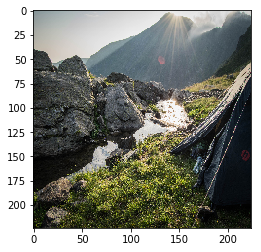

In [3]:
img2 = load_image('DSC_0897')
image, label = foolbox.utils.imagenet_example()
assert (img2.shape, img2.max(), type(img2))==(image.shape, image.max(), type(image))

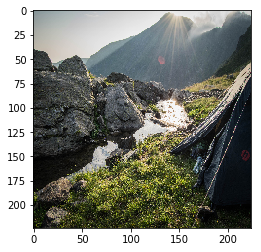

In [4]:
import keras
import numpy as np
from keras.applications.resnet50 import ResNet50

# instantiate model
keras.backend.set_learning_phase(0)
kmodel = ResNet50(weights='imagenet')
preprocessing = (np.array([104, 116, 123]), 1)
fmodel = foolbox.models.KerasModel(kmodel, bounds=(0, 255), preprocessing=preprocessing)

image = load_image('DSC_0897')
to_classify = np.expand_dims(image, axis=0)
preds = kmodel.predict(to_classify)
label = np.argmax(preds)

# apply attack on source image
# ::-1 reverses the color channels, because Keras ResNet50 expects BGR instead of RGB
attack = foolbox.attacks.FGSM(fmodel, threshold=.5)
adversarial = attack(image[:, :, ::-1], label)
# if the attack fails, adversarial will be None and a warning will be printed

In [5]:
print('Predicted:', pp.pprint(decode_predictions(preds, top=20)[0]))

[('n03792972', 'mountain_tent', 0.68727505),
 ('n09399592', 'promontory', 0.07355865),
 ('n09468604', 'valley', 0.07171795),
 ('n04606251', 'wreck', 0.025214558),
 ('n09428293', 'seashore', 0.018810693),
 ('n01498041', 'stingray', 0.01020383),
 ('n04366367', 'suspension_bridge', 0.00910297),
 ('n02077923', 'sea_lion', 0.008893944),
 ('n09472597', 'volcano', 0.0077157747),
 ('n09421951', 'sandbar', 0.0056634448),
 ('n09193705', 'alp', 0.0052817613),
 ('n09256479', 'coral_reef', 0.005070684),
 ('n03042490', 'cliff_dwelling', 0.0048538684),
 ('n03788365', 'mosquito_net', 0.0040941825),
 ('n03450230', 'gown', 0.003981212),
 ('n09246464', 'cliff', 0.0034005924),
 ('n04507155', 'umbrella', 0.00259821),
 ('n09332890', 'lakeside', 0.0024168892),
 ('n02951358', 'canoe', 0.0020540736),
 ('n03160309', 'dam', 0.0020333952)]
Predicted: None


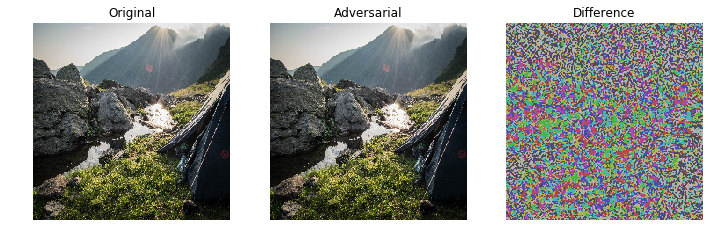

In [6]:
plt.figure(figsize=(12,12))

plt.subplot(1, 3, 1)
plt.title('Original')
plt.imshow(image / 255)  # division by 255 to convert [0, 255] to [0, 1]
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Adversarial')
plt.imshow(adversarial[:, :, ::-1] / 255)  # ::-1 to convert BGR to RGB
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Difference')
difference = adversarial[:, :, ::-1] - image
plt.imshow(difference / abs(difference).max() * 0.2 + 0.5)
plt.axis('off')

plt.show()

In [7]:
new_preds = kmodel.predict(np.expand_dims(adversarial, axis=0))
print('Predicted:', pp.pprint(decode_predictions(new_preds, top=20)[0]))

[('n04366367', 'suspension_bridge', 0.27551892),
 ('n03792972', 'mountain_tent', 0.26759607),
 ('n09472597', 'volcano', 0.25710547),
 ('n09468604', 'valley', 0.09390604),
 ('n09193705', 'alp', 0.03466299),
 ('n09246464', 'cliff', 0.030121733),
 ('n04346328', 'stupa', 0.008299703),
 ('n09399592', 'promontory', 0.0055106645),
 ('n09332890', 'lakeside', 0.0038562394),
 ('n03160309', 'dam', 0.0020365235),
 ('n02965783', 'car_mirror', 0.0017434784),
 ('n03788365', 'mosquito_net', 0.0015232521),
 ('n04275548', 'spider_web', 0.0014818179),
 ('n04613696', 'yurt', 0.0013899272),
 ('n03891251', 'park_bench', 0.0012903691),
 ('n02104365', 'schipperke', 0.001013231),
 ('n02667093', 'abaya', 0.0010092475),
 ('n09428293', 'seashore', 0.00091121765),
 ('n02951358', 'canoe', 0.0007187614),
 ('n03000134', 'chainlink_fence', 0.0005480902)]
Predicted: None


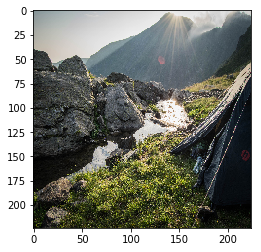

In [8]:
plt.imshow(image / 255)

In [9]:
# !wget https://github.com/GANs-in-Action/gans-in-action/raw/Chapter-10/chapter-10/DSC_0897.jpg
# !wget https://github.com/GANs-in-Action/gans-in-action/raw/Chapter-10/chapter-10/DSC_0896.jpg

In [10]:
mu_list = range(50, 200, 10)
sigma_list = range(10, 100, 2)
storage_df = pd.DataFrame()

for mu, sigma in zip(mu_list, sigma_list):
    rand_noise = np.random.normal(loc=mu, scale=sigma, size=(224,224, 3))
    rand_noise = np.clip(rand_noise, 0, 255.)
    noise_preds = kmodel.predict(np.expand_dims(rand_noise, axis=0))
    predictions = decode_predictions(noise_preds, top=20)[0]
    new_df = pd.DataFrame(predictions, columns=['id','class','prediction'])
    new_df['sigma'] = sigma
    new_df['mu'] = mu
    storage_df = pd.concat([new_df, storage_df])
    

In [11]:
descr = storage_df.groupby(['sigma','mu']).describe()
max_vals = descr.prediction['max'].sort_values(ascending=False).reset_index()
max_vals

sigma   mu       max
0      12   60  0.147369
1      28  140  0.126801
2      14   70  0.105238
3      26  130  0.102846
4      10   50  0.093071
5      32  160  0.087750
6      18   90  0.085806
7      22  110  0.084853
8      20  100  0.083923
9      30  150  0.074985
10     38  190  0.072314
11     24  120  0.069501
12     16   80  0.068732
13     36  180  0.056705
14     34  170  0.056467

In [12]:
sigma_list = list(max_vals.sigma)
mu_list = list(max_vals.mu)

In [13]:
rand_noise = np.random.normal(loc=60, scale=12, size=(224,224, 3))
rand_noise = np.clip(rand_noise, 0, 255.)
noise_preds = kmodel.predict(np.expand_dims(rand_noise, axis=0))
predictions = decode_predictions(noise_preds, top=20)[0]
new_df = pd.DataFrame(predictions, columns=['id','class','prediction'])
new_df['sigma'] = sigma
new_df['mu'] = mu
new_df

id          class  prediction  sigma   mu
0   n01776313           tick    0.129975     38  190
1   n04548280     wall_clock    0.043860     38  190
2   n02783161      ballpoint    0.026409     38  190
3   n04266014  space_shuttle    0.026014     38  190
4   n04372370         switch    0.025394     38  190
5   n01828970      bee_eater    0.023286     38  190
6   n01608432           kite    0.022784     38  190
7   n04153751          screw    0.021387     38  190
8   n02002724    black_stork    0.019948     38  190
9   n03291819       envelope    0.017791     38  190
10  n02264363       lacewing    0.017105     38  190
11  n04070727   refrigerator    0.014189     38  190
12  n01616318        vulture    0.013560     38  190
13  n01560419         bulbul    0.012639     38  190
14  n01614925     bald_eagle    0.012527     38  190
15  n03207941     dishwasher    0.012359     38  190
16  n03888257      parachute    0.011344     38  190
17  n03729826     matchstick    0.009456     38  190
18  n04127249     safety_pin    0.008776     38  190
19  n03773504        missile    0.008602     38  190

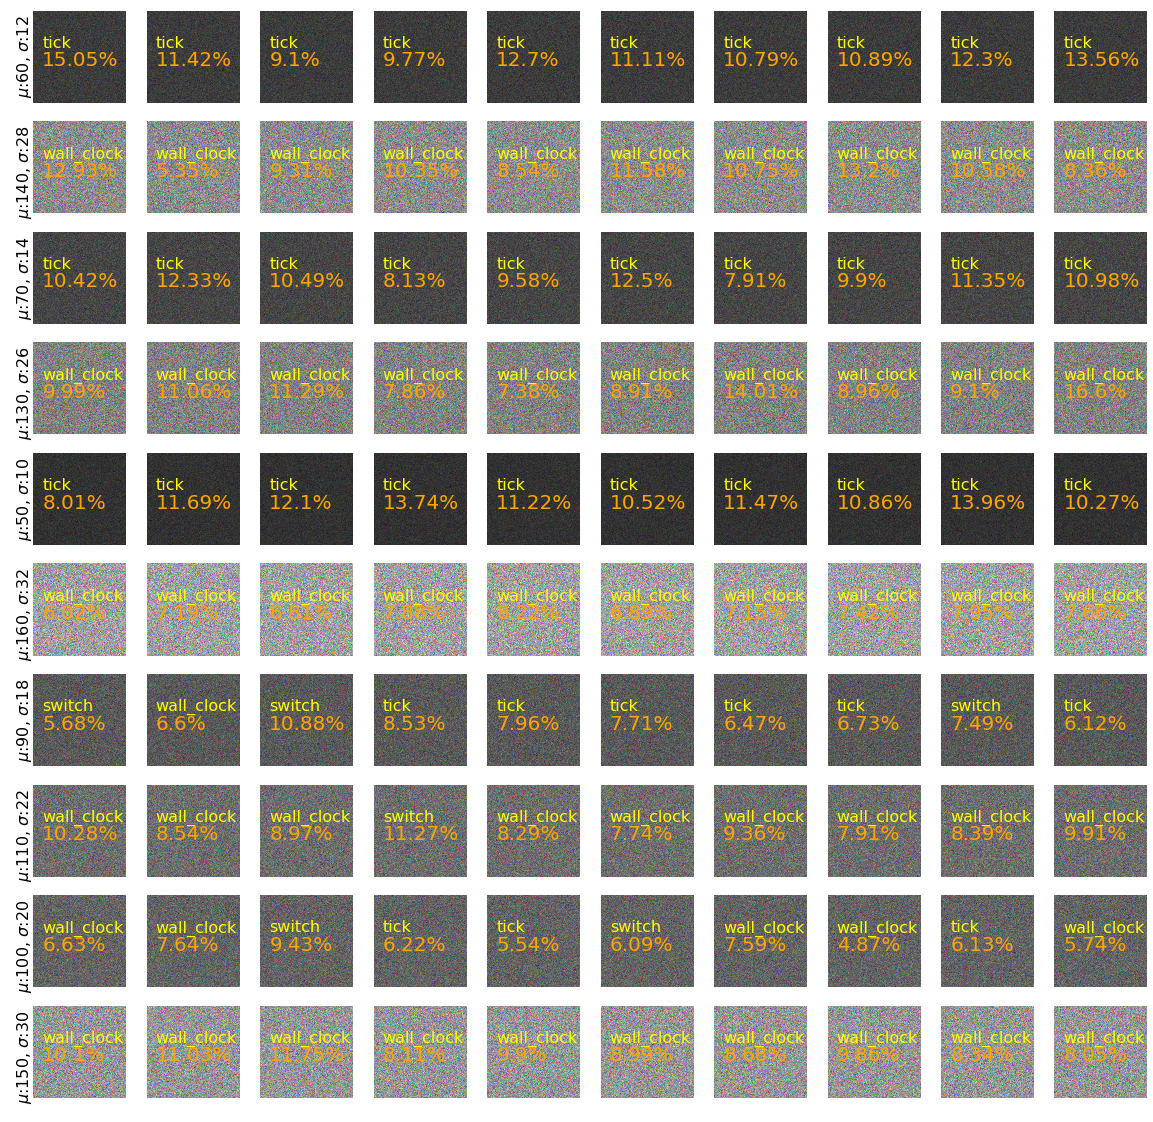

In [14]:
fig = plt.figure(figsize=(20,20))
mu = 50
sigma = 10
sigma_list = list(max_vals.sigma)
mu_list = list(max_vals.mu)
conf_list = []

def make_subplot(x, y, z, new_row=False):
    rand_noise = np.random.normal(loc=mu, scale=sigma, size=(224,224, 3))
    rand_noise = np.clip(rand_noise, 0, 255.)
    noise_preds = kmodel.predict(np.expand_dims(rand_noise, axis=0))
    prediction, num = decode_predictions(noise_preds, top=20)[0][0][1:3]
    num = round(num * 100, 2)
    conf_list.append(num)
    ax = fig.add_subplot(x,y,z)
    ax.annotate(prediction, xy=(0.1, 0.6), xycoords=ax.transAxes, fontsize=16, color='yellow')
    ax.annotate(f'{num}%' , xy=(0.1, 0.4), xycoords=ax.transAxes, fontsize=20, color='orange')
    if new_row:
        ax.annotate(f'$\mu$:{mu}, $\sigma$:{sigma}' , xy=(-.2, 0.8), xycoords=ax.transAxes,
                    rotation=90, fontsize=16, color='black')
    ax.imshow(rand_noise / 255)  # division by 255 to convert [0, 255] to [0, 1]
    ax.axis('off')

    
for i in range(1,101):
    if (i-1) % 10==0:
        mu = mu_list.pop(0)
        sigma = sigma_list.pop(0)
        make_subplot(10,10, i, new_row=True)
    else:
        make_subplot(10,10, i)

plt.show()

# Now let's try applying an adversarial attack
Keeping `ResNet50` as our prediction network, let's now try to attack the Gaussian noise we have classified above. 

In [ ]:
rand_noise = np.random.normal(loc=mu, scale=sigma, size=(224,224, 3))
rand_noise = np.clip(rand_noise, 0, 255.)
first_pred = kmodel.predict(np.expand_dims(rand_noise, axis=0))
label = np.argmax(first_pred)
attack = foolbox.attacks.LBFGSAttack(fmodel, 
                                     distance=foolbox.distances.MAE,
                                     criterion=ConfidentMisclassification(.9))
adversarial = attack(rand_noise[:, :, ::-1], label)
# adversarial = adversarial.image
noise_preds = kmodel.predict(np.expand_dims(adversarial, axis=0))
prediction, num = decode_predictions(noise_preds, top=20)[0][0][1:3]
num = round(num * 100, 2)
print(prediction, num)
sum_pred.append(num)

In [ ]:
fig = plt.figure(figsize=(20,20))
mu = 50
sigma = 10
sigma_list = list(max_vals.sigma)
mu_list = list(max_vals.mu)
sum_pred = []

def make_subplot(x, y, z, new_row=False):
    rand_noise = np.random.normal(loc=mu, scale=sigma, size=(224,224, 3))
    rand_noise = np.clip(rand_noise, 0, 255.)
    first_pred = kmodel.predict(np.expand_dims(rand_noise, axis=0))
    label = np.argmax(first_pred)
    attack = foolbox.attacks.LBFGSAttack(fmodel, 
                                         distance=foolbox.distances.MAE,
                                         criterion=ConfidentMisclassification(.75))
    adversarial = attack(rand_noise[:, :, ::-1], label)
    # adversarial = adversarial.image
    noise_preds = kmodel.predict(np.expand_dims(adversarial, axis=0))
    prediction, num = decode_predictions(noise_preds, top=20)[0][0][1:3]
    num = round(num * 100, 2)
    print(prediction, num)
    sum_pred.append(num)
    ax = fig.add_subplot(x,y,z)
    ax.annotate(prediction, xy=(0.1, 0.6), xycoords=ax.transAxes, fontsize=16, color='yellow')
    ax.annotate(f'{num}%', xy=(0.1, 0.4), xycoords=ax.transAxes, fontsize=20, color='orange')
    if new_row:
        ax.annotate(f'$\mu$:{mu}, $\sigma$:{sigma}' , xy=(-.2, 0.8), xycoords=ax.transAxes,
                    rotation=90, fontsize=16, color='black')
    ax.imshow(adversarial / 255)  # division by 255 to convert [0, 255] to [0, 1]
    ax.axis('off')

    
for i in range(1,101):
    if (i-1) % 10==0:
        mu = mu_list.pop(0)
        sigma = sigma_list.pop(0)
        make_subplot(10,10, i, new_row=True) 
    else:
        make_subplot(10,10, i)

plt.show()

tick 10.7
tick 13.52
tick 12.1
tick 15.51
tick 7.59


/anaconda3/envs/teaching/lib/python3.6/site-packages/foolbox/attacks/base.py:148: UserWarning: GradientAttack did not find an adversarial, maybe the model or the criterion is not supported by this attack.
  ' attack.'.format(self.name()))


tick 14.15


wall_clock 8.87


tick 22.83


tick 8.05
tick 9.56


switch 5.22


wall_clock 8.73


wall_clock 7.33


envelope 9.78


lampshade 5.41


wall_clock 5.89


envelope 7.08


wall_clock 7.18


envelope 20.97


wall_clock 9.62


tick 22.85


tick 8.64


switch 8.97
tick 7.0
tick 13.29
tick 9.9


tick 8.04


tick 8.42


tick 8.59
tick 12.03


envelope 3.51


wall_clock 4.02


envelope 9.84
wall_clock 6.19


quill 12.6


switch 5.74


wall_clock 7.21
wall_clock 5.03


wall_clock 6.53


wall_clock 3.14


wall_clock 10.69


tick 6.58


tick 8.62
tick 8.34
tick 8.96


wall_clock 10.08
tick 13.99


tick 13.91
tick 11.1


switch 11.07


screw 4.24


wall_clock 6.21


wall_clock 6.0


wall_clock 4.78


wall_clock 5.58


screw 4.3


screw 4.51


lampshade 3.47


wall_clock 5.03


wall_clock 4.56


wall_clock 4.24


lacewing 8.88


kite 13.33


envelope 8.76


switch 13.55


envelope 5.27


envelope 20.26


envelope 8.43


# Now let's try the same thing with `InceptionV3`
This is another standard classifier, which, however, fails spectacularly.

In [25]:
from keras.applications.inception_v3 import InceptionV3

# instantiate model
keras.backend.set_learning_phase(0)
kmodel_v3 = InceptionV3(weights='imagenet')
preprocessing = (np.array([104, 116, 123]), 1)
fmodel_v3 = foolbox.models.KerasModel(kmodel, bounds=(0, 255), preprocessing=preprocessing)

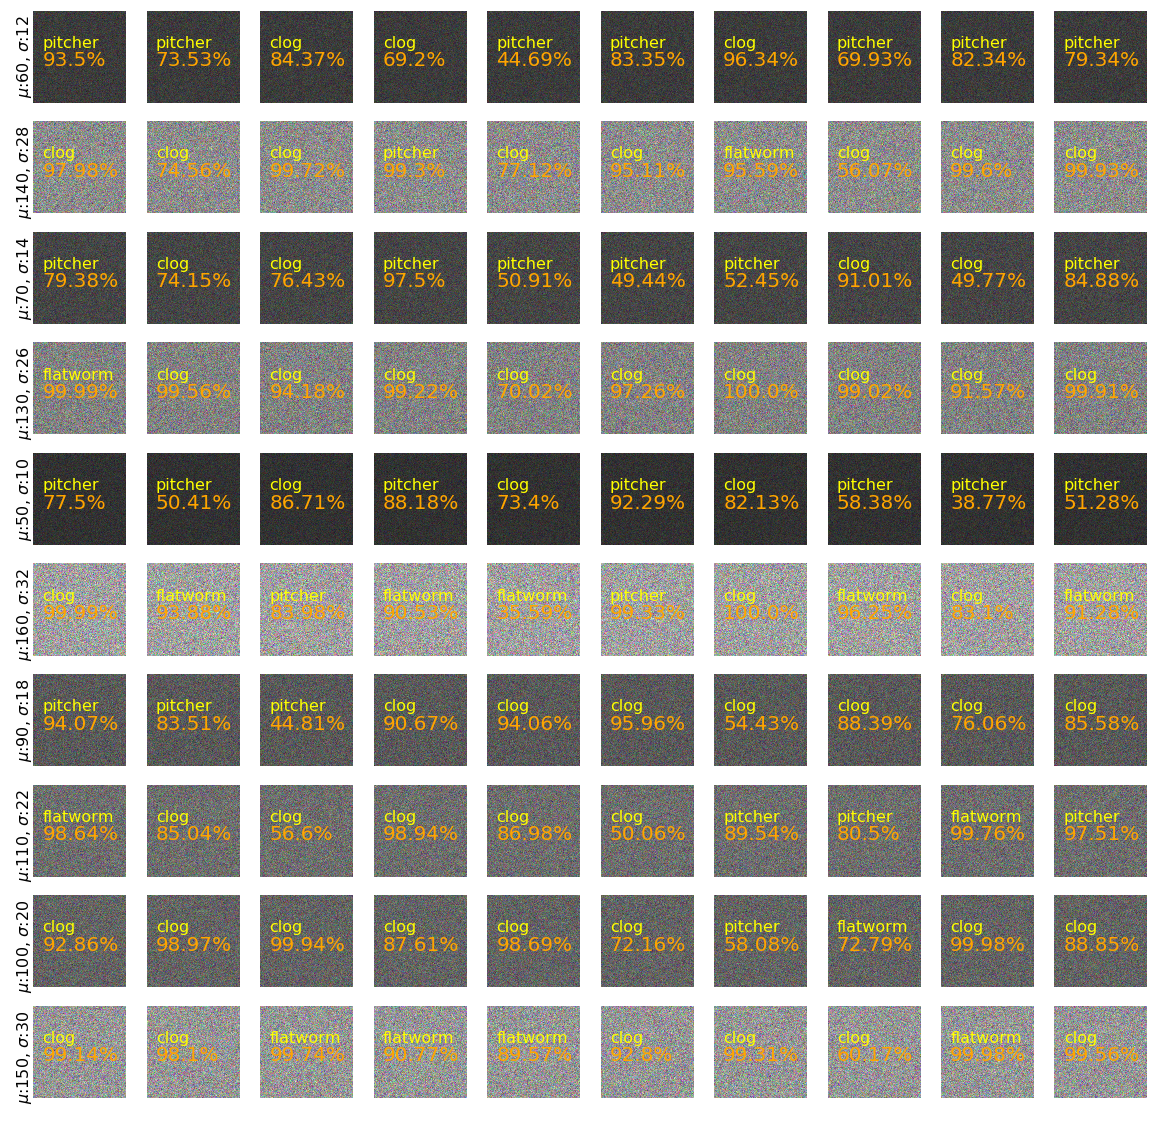

In [23]:
fig = plt.figure(figsize=(20,20))
mu = 50
sigma = 10
sigma_list = list(max_vals.sigma)
mu_list = list(max_vals.mu)
conf_list = []

def make_subplot(x, y, z, new_row=False):
    rand_noise = np.random.normal(loc=mu, scale=sigma, size=(224,224, 3))
    rand_noise = np.clip(rand_noise, 0, 255.)
    noise_preds = kmodel_v3.predict(np.expand_dims(rand_noise, axis=0))
    prediction, num = decode_predictions(noise_preds, top=20)[0][0][1:3]
    num = round(num * 100, 2)
    conf_list.append(num)
    ax = fig.add_subplot(x,y,z)
    ax.annotate(prediction, xy=(0.1, 0.6), xycoords=ax.transAxes, fontsize=16, color='yellow')
    ax.annotate(f'{num}%' , xy=(0.1, 0.4), xycoords=ax.transAxes, fontsize=20, color='orange')
    if new_row:
        ax.annotate(f'$\mu$:{mu}, $\sigma$:{sigma}' , xy=(-.2, 0.8), xycoords=ax.transAxes,
                    rotation=90, fontsize=16, color='black')
    ax.imshow(rand_noise / 255)  # division by 255 to convert [0, 255] to [0, 1]
    ax.axis('off')

    
for i in range(1,101):
    if (i-1) % 10==0:
        mu = mu_list.pop(0)
        sigma = sigma_list.pop(0)
        make_subplot(10,10, i, new_row=True)
    else:
        make_subplot(10,10, i)

plt.show()

In [ ]:
# Let's now look at how this all works under the hood
## maybe move this to the beginning?

In [ ]:
max_vals.to_csv('max_vals.csv')

In [ ]:
fmodel.predictions??

In [ ]:
fmodel.predictions